In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import npts

DATA_DIR = 'data/'

In [2]:
def load_year(year):
    ## Look at the document in DATA_DIR for spec.
    data=pd.read_csv(DATA_DIR+f'{year}-SFO-weather.csv.gz', usecols=[1,13])
    data.index = pd.to_datetime(data.DATE, format='%Y-%m-%dT%H:%M:%S')
    data = data.dropna()
    data['temp'] = data.TMP.apply(lambda el: float(el.split(',')[0])/10.)
    data['qual_code'] = data.TMP.apply(lambda el: (el.split(',')[1]))
    # time zone
    import pytz
    pacific = pytz.timezone('US/Pacific')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(pacific)

    return data.temp[data.qual_code.isin(['1','5'])]

temperatures = pd.Series()
for year in range(1987, 2019):
    temperatures = temperatures.append(load_year(year))

In [3]:
print('we have years:', set(temperatures.index.year))
data_used = temperatures[temperatures.index.year <= 2015]
indep_test = temperatures[temperatures.index.year > 2015]

we have years: {1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018}


In [4]:
tropical_year_seconds = 365.24219 * 86400

In [30]:
import itertools


def to_seconds(index):
    """Given a TS index, return the seconds from Jan 1st, 2000."""
    return (index - pd.Timestamp('2000-01-01', tz=index.tz)).total_seconds()


def basis_apply(func, period, harmonic, index_count):
    return func(2 * np.pi * harmonic * index_count / period)


class HarmonicFit(object):
    def __init__(self, periods_seconds, max_harmonics=5):
        self.periods_seconds = periods_seconds
        self.max_harmonics = max_harmonics
        
    def bases_iter(self, n_harmonics):
        bases = list(itertools.product((np.sin, np.cos), 
                                  self.periods_seconds, 
                                  range(1, n_harmonics+1)))
        return itertools.chain([(np.cos, 1, 0.)], bases)        
        
    def featurize(self, data_index, n_harmonics):
        """Makes features matrix for index, iter of periods (in sec.), and num. of harmonics."""
        
        n_features = 1 + len(self.periods_seconds) * n_harmonics * 2
        index_seconds = to_seconds(data_index)
        X = np.empty((len(data_index), n_features))
        for i, base in enumerate(self.bases_iter(n_harmonics)):
            X[:, i] = basis_apply(*base, index_seconds)
        return X
        
    def fit(self, data, train_frac = .75):
        
        mask = np.random.uniform(size=len(data)) <= train_frac
        
        self.betas = {}
        self.val_costs = {}
        
        for n_harmonics in range(1, self.max_harmonics+1):
            X_tr = self.featurize(data.index[mask], n_harmonics)
            y_tr = data.values[mask]
            X_val = self.featurize(data.index[~mask], n_harmonics)
            y_val = data.values[~mask]
            self.betas[n_harmonics] = np.linalg.solve(X_tr.T @ X_tr, X_tr.T @ y_tr)
            self.val_costs[n_harmonics] = np.sqrt(np.mean((X_val@self.betas[n_harmonics] - y_val)**2))
            
        self.beta = self.betas[self.best_n_harmonic]
            
    @property
    def best_n_harmonic(self):
        return min(self.val_costs, key=self.val_costs.get)

    def predict(self, test_index):
        X = self.featurize(test_index, self.best_n_harmonic)
        return pd.Series(index=test_index, data = X@self.beta)

In [31]:
model = HarmonicFit([86400, 365.24219 * 86400])

def sparsify_data(data, frac):
    return data[np.random.uniform(size=len(data)) < frac]

model.fit(sparsify_data(data_used, 1.))
pred = model.predict(indep_test.index)

In [32]:
model.val_costs

{1: 2.6211765988314553,
 2: 2.4971842150818033,
 3: 2.4810455377629159,
 4: 2.4785822881019364,
 5: 2.4781010747885017}

In [33]:
print(f'RMSE {np.sqrt(np.mean((indep_test - pred)**2))}')

RMSE 2.6121316933194842


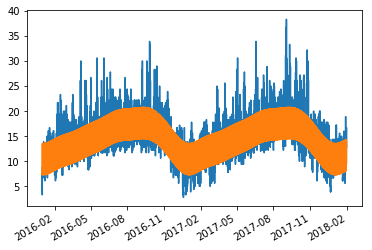

In [34]:
indep_test.plot()
pred.plot()

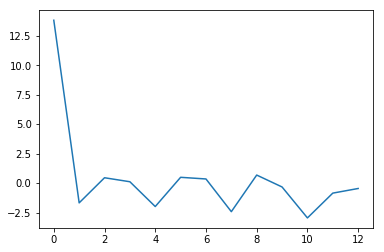

In [34]:
plt.plot(model.beta)

In [ ]:
np.empty

In [58]:
si,co=_second_features(_to_seconds(data_used.index), 365*86400, 5)

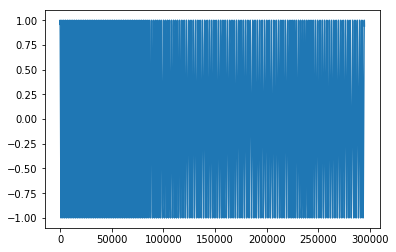

In [59]:
plt.plot(co)

In [48]:
def _to_seconds(index):
    """Given a TS index, return the seconds from Jan 1st, 2000."""
    return (index - pd.Timestamp('2000-01-01', tz=index.tz)).total_seconds()

def _second_features(index_seconds, period, harmonic):
    """Return sine and cosine harmonic for seconds of index."""
    scaled = 2 * np.pi * harmonic * index_seconds / period
    return np.sin(scaled), np.cos(scaled)


class HarmonicModel(object):

    def __init__(self, periods, verbose=False):
        """Multi periodic smoother
        Args:
            - periods: objects that define n_periods and indexer
            #- indexers is sequence of functions, to apply to data.index,
            #        that return indexes (of each periodicity)
            #- n_periods is number of periods for each
        """
        self.indexers = [el.indexer for el in time_features]
        self.n_periods = [el.n_periods for el in time_features]
        self.K = len(time_features)
        self.verbose = verbose
        self.lambdas = [el.lambdas for el in time_features]
        

    def fit(self, data, train_frac=.8, seed=0, initial_lambda=None,
            compute_tr_costs=False):


        np.random.seed(seed)
        self.compute_tr_costs = compute_tr_costs
        self.initial_lambda = initial_lambda

        self._split_prepare_data(data, train_frac)

        # look at provided lambdas
        if self.verbose:
            print('Provided lambdas:', self.lambdas)

        if compute_tr_costs:
            self.tr_costs = {}
        self.val_costs = {}
        #self.thetas = {}

        self._theta_cache = np.zeros((self.N, self.L))  # for cg warmstart
        self._grad_cache = np.zeros((self.N, self.L))  # for cg warmstart

        self.grid_search_and_numerical_opt()
        self._select_model()
        self._clear_cache()
        


    def _clear_cache(self):
        del self._theta_cache
        del self._grad_cache